In [10]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split


[*********************100%***********************]  1 of 1 completed


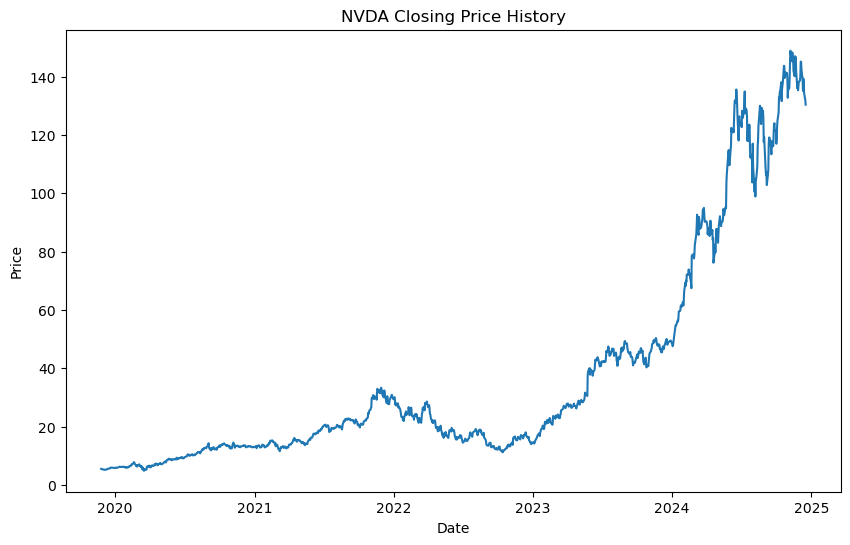

In [11]:
# Download NVDA stock data
start_date = "2019-11-25"
end_date = "2024-12-18"
data = yf.download('NVDA', start=start_date, end=end_date)

# Use closing price for prediction
closing_price = data['Close']

# Plot the closing price
plt.figure(figsize=(10, 6))
plt.plot(closing_price)
plt.title('NVDA Closing Price History')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [12]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_price.values.reshape(-1, 1))

# Prepare the dataset for LSTM
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60  # 60 days
X, y = create_dataset(scaled_data, time_step)

# Reshape X to be a 3D array for LSTM [samples, time_steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Split training data further into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)


In [13]:
# Build the LSTM model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))  # Output layer

model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
from tensorflow import keras
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping and validation data
history = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=1)

Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0027 - val_loss: 4.9032e-04
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.7311e-04 - val_loss: 3.6239e-04
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.6702e-04 - val_loss: 2.8881e-04
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.1918e-04 - val_loss: 3.6501e-04
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.1087e-04 - val_loss: 3.6033e-04
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.8117e-05 - val_loss: 2.6883e-04
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.0241e-04 - val_loss: 2.5753e-04
Epoch 8/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.9068e-05 - val_loss: 5.2867e-04
Epoch 9/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.0388e-04 - val_loss: 2.2608e-04
Epoch 10/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 7.9611e-05 - val_loss: 1.9211e-04
Epoch 11/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.

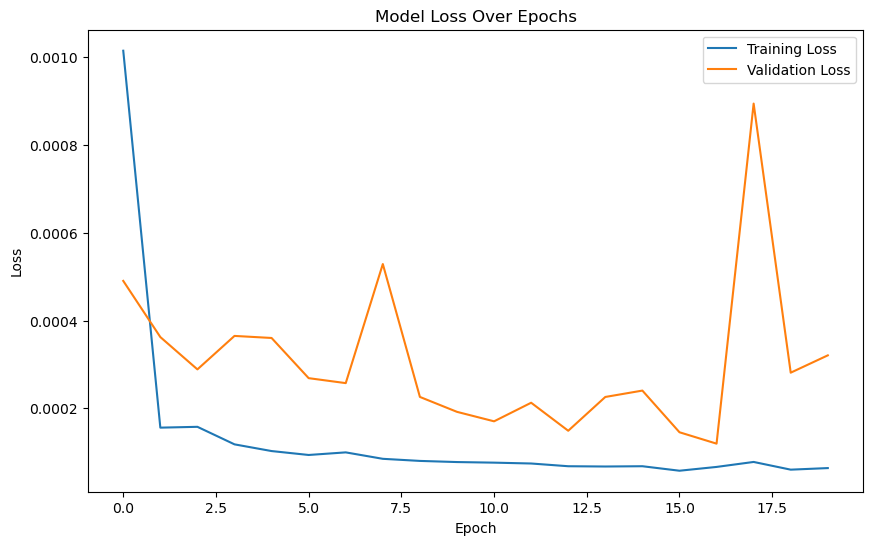

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


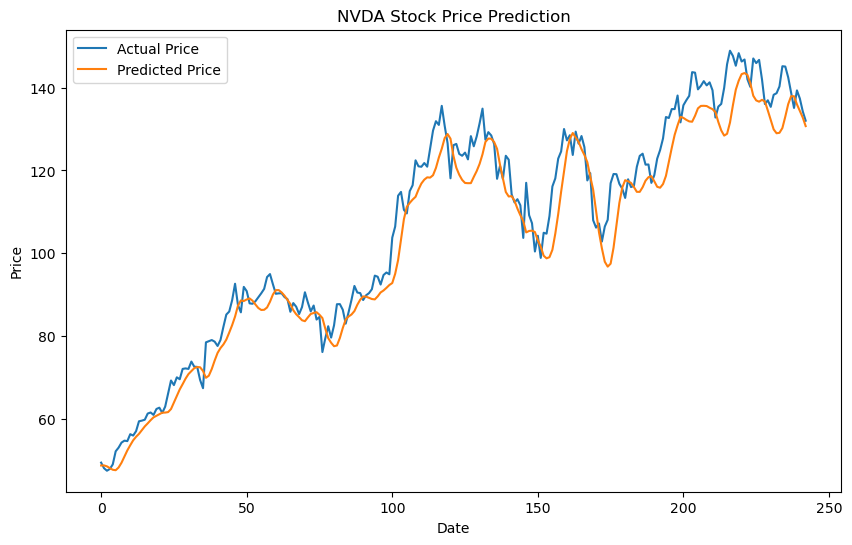

In [16]:
predictions = model.predict(X_test)

# Invert scaling
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual Price')
plt.plot(predictions, label='Predicted Price')
plt.title('NVDA Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()